# Install Library

In [1]:
!pip install arch -q
!git clone https://github.com/numenta/NAB.git -q

fatal: destination path 'NAB' already exists and is not an empty directory.


# Define sRLSTM + AutoEncoder Ensenble Model

In [1]:
from srnn_ae import SLAEE, set_random_seed, hyperparameter_setting, read_dataset
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    roc_auc_score, average_precision_score, cohen_kappa_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import time

In [2]:
set_random_seed()
args = hyperparameter_setting(N=1, batch_size=20, num_epochs=300)
model = SLAEE(
    N=args['N'], 
    input_size=args['input_size'],
    hidden_size=args['hidden_size'],
    output_size=args['output_size'],
    num_layers=args['num_layers'],
    limit_skip_steps=args['limit_skip_steps'],
    seed=args['random_seed']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Test w/ sine wave data

In [3]:
# -------------------------------
# 3. 데이터 생성 (사인파 시퀀스)
# -------------------------------

def generate_sine_wave(seq_length, batch_size, input_size=1):
    """
    사인파 시퀀스를 생성합니다.
    
    Args:
        seq_length (int): 시퀀스의 길이 (타임 스텝 수)
        batch_size (int): 배치 크기
        input_size (int): 입력 피처의 수 (기본값: 1)
    
    Returns:
        np.ndarray: 생성된 사인파 데이터, shape (batch_size, seq_length, input_size)
    """
    x = np.linspace(0, 2 * np.pi, seq_length)
    data = []
    for _ in range(batch_size):
        phase = np.random.uniform(0, 2 * np.pi)
        amplitude = np.random.uniform(0.5, 1.5)
        sine_wave = amplitude * np.sin(x + phase)
        noise = np.random.normal(0, 0.1, size=x.shape)
        sine_wave += noise
        data.append(sine_wave)
    data = np.array(data)  # shape (batch_size, seq_length)
    data = data[..., np.newaxis]  # shape (batch_size, seq_length, 1)
    return data

# 입력과 타겟 데이터 생성
batch_size = 32
seq_length = 20
input_size = 1
output_size = 1
inputs = generate_sine_wave(seq_length, batch_size, input_size)
targets = generate_sine_wave(seq_length, batch_size, output_size)

# 텐서로 변환하고 시퀀스 차원 (seq_len, batch_size, input_size)으로 변환
inputs = torch.tensor(inputs, dtype=torch.float32).transpose(0, 1).to(device)
targets = torch.tensor(targets, dtype=torch.float32).transpose(0, 1).to(device)

# -------------------------------
# 4. 손실 함수 및 옵티마이저 정의
# -------------------------------

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------------
# 5. 학습 루프 실행
# -------------------------------

model.train()
num_epochs = 500

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # 순전파
    outputs = model(inputs, targets)
    
    # 손실 계산
    loss = criterion(outputs, targets)
    
    # 역전파
    loss.backward()
    optimizer.step()
    
    # 주기적으로 손실 출력
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# -------------------------------
# 6. 모델의 성능 평가
# -------------------------------

model.eval()
with torch.no_grad():
    # 테스트 데이터 생성
    test_inputs = generate_sine_wave(seq_length, batch_size, input_size)
    test_targets = generate_sine_wave(seq_length, batch_size, output_size)
    
    # 텐서로 변환하고 시퀀스 차원으로 변환
    test_inputs = torch.tensor(test_inputs, dtype=torch.float32).transpose(0, 1).to(device)
    test_targets = torch.tensor(test_targets, dtype=torch.float32).transpose(0, 1).to(device)
    
    # 순전파
    test_outputs = model(test_inputs, test_targets)
    
    # 손실 계산
    test_loss = criterion(test_outputs, test_targets)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [50/500], Loss: 0.3617
Epoch [100/500], Loss: 0.2851
Epoch [150/500], Loss: 0.2178
Epoch [200/500], Loss: 0.3052
Epoch [250/500], Loss: 0.1436
Epoch [300/500], Loss: 0.1429
Epoch [350/500], Loss: 0.0993
Epoch [400/500], Loss: 0.1143
Epoch [450/500], Loss: 0.1017
Epoch [500/500], Loss: 0.1118
Test Loss: 0.1083


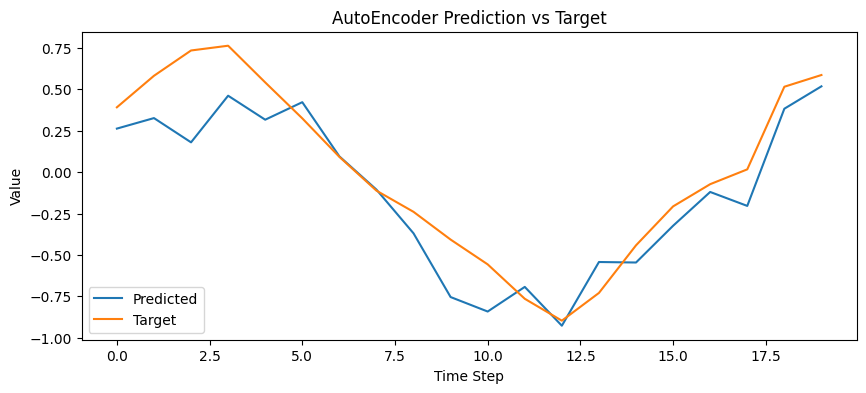

In [4]:
import matplotlib.pyplot as plt

with torch.no_grad():
    # 첫 번째 배치의 첫 번째 시퀀스를 선택
    pred = test_outputs[:, 0, 0].cpu().numpy()
    target = test_targets[:, 0, 0].cpu().numpy()
    
    plt.figure(figsize=(10, 4))
    plt.plot(pred, label='Predicted')
    plt.plot(target, label='Target')
    plt.legend()
    plt.title('AutoEncoder Prediction vs Target')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.show()